In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

import numpy as np
from matplotlib import pyplot as plt

from models import CNN1D_1l_RNN, HiPPO
from model.model import Model
from train import train_lambda, eval_lambda

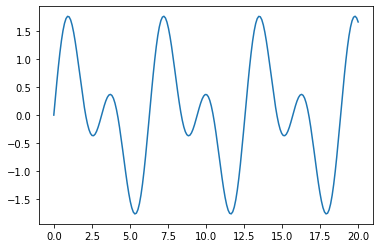

In [2]:
signal = lambda t: np.sin(t) + np.sin(2*t)# + t# + np.random.normal(loc=0.0, scale=0.3, size=t.shape)
ticks = np.linspace(0, 20, 200)
plt.plot(ticks, signal(ticks))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
torch.manual_seed(1)
f = 128
bs=512
tr = 48
lr=0.0005
e=1200

  0%|          | 0/1200 [00:00<?, ?it/s]

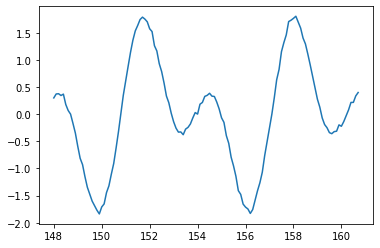

In [4]:
lstm = CNN1D_1l_RNN(16, int(tr/0.1), stacked=3, future = f, cell_type="LSTM")
train_lambda(lstm, signal, future = f, time_range=tr, epochs = e, batch_size=bs, lr=lr, dev = device)

  0%|          | 0/1200 [00:00<?, ?it/s]

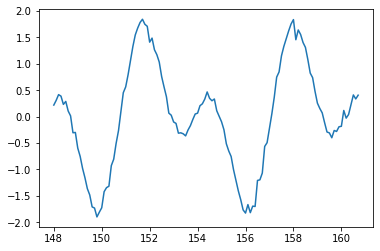

In [5]:
gru = CNN1D_1l_RNN(16, int(tr/0.1), stacked=3, future = f, cell_type="GRU")
train_lambda(gru, signal, future = f, time_range=tr, epochs = e, dev = device, lr=0.0003, batch_size=bs)

  0%|          | 0/1200 [00:00<?, ?it/s]

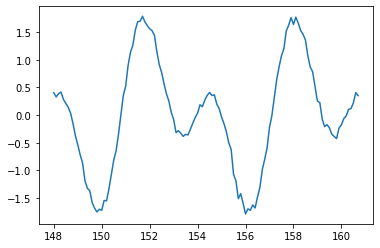

In [6]:
hippo = HiPPO(64, 1, f)
#hippo = Model(1, 1, f, cell='orthogonal', cell_args={'hidden_size':32})
train_lambda(hippo, signal, future = f, time_range=tr, epochs = e, dev = device, batch_size=bs,lr=lr)

In [7]:
#eval_lambda(hippo, signal, time_range=tr)